# Assignment 1 - SED Fitting

## Error estimation

This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Error Estimation module

The SETUP section is designed to be done first, to familarize yourself with the data and the details of SED fitting. Section 1 is shorter to account for this

Feel free to write functions in a separate module and import them here if you like

# SETUP

- Download the data from [here](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html) (both the input and output catalog). These come from [Chang et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....8C/abstract)

- Install [Prospector](https://github.com/bd-j/prospector) (we found this easiest to do using the [conda script](https://github.com/bd-j/prospector/blob/main/conda_install.sh) provided)

- Pick a galaxy in the *input* data (this can be any row with FLAG=1)

- Use prospector to fit an SED model (pick any model you like) to your chosen galaxy

    - To do this we recommend following the [quickstart guide](https://prospect.readthedocs.io/en/latest/quickstart.html) in the prospector documentation and adapting to our data 


- Now repeat for a few different galaxies (try to pick a range of magnitudes, redshifts, etc)

- Try using a model with a fixed redshift (using the spectroscopic redshift in the catalog) vs fitting the redshift from the photometry

########

###Do we want to provide a working example for our data?

########

In [34]:
import prospect.io.read_results as reader
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("demo_{}_mcmc.h5".format(results_type), dangerous=False)


In [31]:
styling = {
        'text.usetex' : True,
        'lines.linewidth' : 2,
        'font.sans-serif' : 'Times New Roman',
        'font.family' : 'sans-serif',
        'axes.labelsize' : 15,
        'legend.fontsize' : 15,
        'font.size' : 15,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        'ytick.major.size' : 8,
        'ytick.minor.size' : 4,
        'xtick.major.size' : 10,
        'xtick.minor.size' : 6,
        'xtick.direction' : 'inout',
        'ytick.direction' : 'inout',  
}

mpl.rcParams.update(styling)

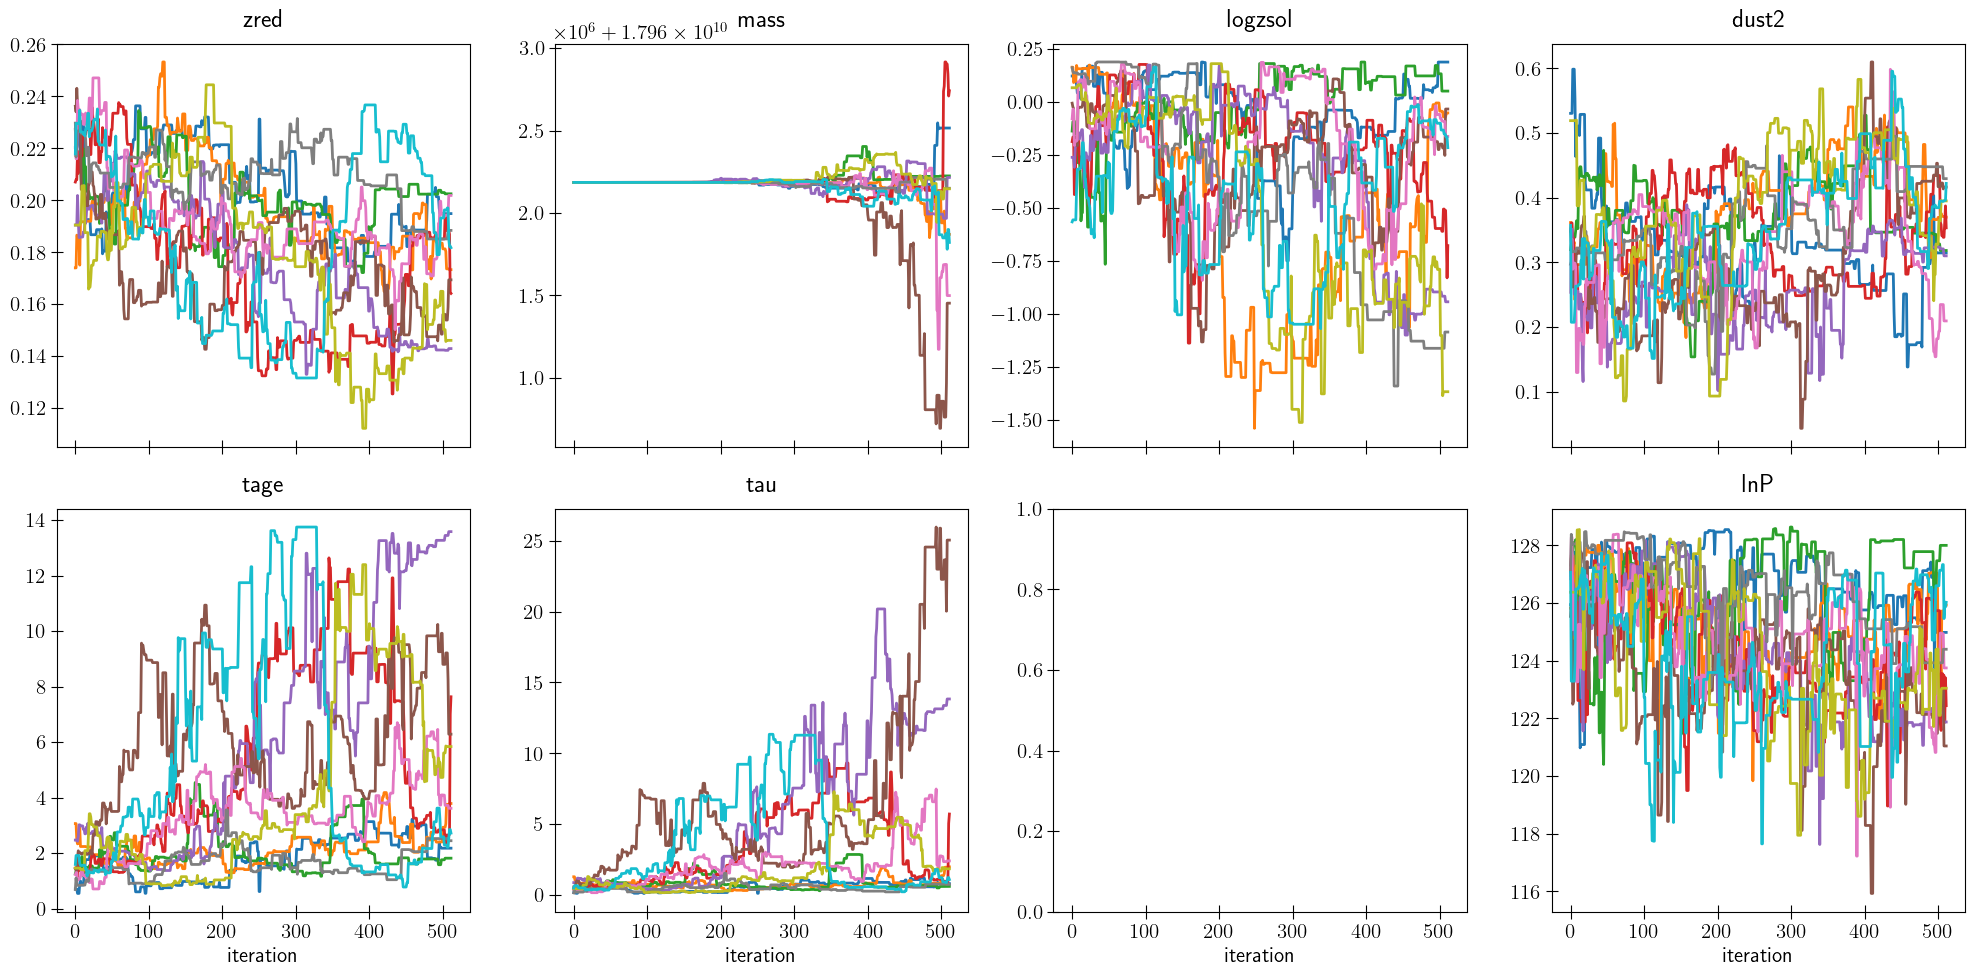

In [35]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))

In [ ]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)


# SECTION 1

- #### Goodness of fit of Prospector examples

In [21]:
### Plot the data for a chosen galaxy (with error bars) 
### Flux or magnitude vs band wavelength or index

### Add the best fit model to the plot

### Compute the goodness-of-fit (chi squared)
### (Prospector assumes the magnitudes are independent so you can to, but we'll come back to this later)

In [22]:
wspec = sps.wavelengths
a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting

wspec *= a #redshift them

In [28]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from(hfile, dangerous=False)
z

{'model_params': [{'N': 1,
   'isfree': True,
   'init': 0.1,
   'units': 'redshift',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05K\x00h\x06K\x01uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'zred'},
  {'N': 1,
   'isfree': True,
   'init': 10000000000.0,
   'units': 'Solar masses formed',
   'prior': b'\x80\x02cprospect.models.priors\nLogUniform\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05GA\x97\xd7\x84\x00\x00\x00\x00h\x06GBm\x1a\x94\xa2\x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.5,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x0

In [24]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

IndexError: index 79 is out of bounds for axis 0 with size 32

In [36]:
### Is the goodness of fit reasonable (why?)

In [52]:
### What is the best fit, mean, and 1/2/3 sigma confidence intervals for each of the constrained parameters
### Are they consistent with the results from Chang et al (the output file linked above)?
### How similar do we expect them to be?

In [38]:
### How did allowing the redshift as a free parameter change the results? did you get the same mass? is the redshift correct?

# SECTION 2 

- #### Covariance of contrained parameters (Gaussian assumption)

In [39]:
### First lets look at the covariance of constrained parameters
### Plot a corner plot of the prospector outputs, showing the 68% and 95% 2D contours
### (You will want to use one of the MCMC methods in the prospector fitting ...
###    we will discuss this more in the MCMC section. For now we can assume that the density of ...
###    output samples at a given location in parameter space, is proportional to the probability of ...
###    those parameters, given the data and model )

In [40]:
### Are there any degeneracies between parameters in the fit?
### What does this mean?

In [41]:
### Make a covarinace matrix of the fitted parameters (describing the uncertainties and their covarinace with each other) 
### Plot it
### Looking at the contour plot, was this a reasonable thing to do?

- #### Covariance of magnitude errors

In [42]:
### So far, prospector has assumed the uncertainties in the magnitudes/fluxes are independent of each other 
### In practice this might not be true
### For this excercise, assume the correlation between the flux in each band is X%
### Plot the covariance matrix, with and without the correlated errors

In [43]:
### Re-compute the goodness of fit with the correlated errors

In [44]:
### Did the goodness-of-fit get worse or better, why?

# SECTION 3 

Estimating error bars and uncertainty of distributions (shot noise, bootstrap)

In [45]:
### For this section we will use the output catalogs, since running prospector on all 
### 800000 galaxies would be a waste of computing for this class

### Plot a histogram of a given measured quantity (stellar mass, redshift, etc) 
### Choose the range and bin size appropriately so that we can see the full distribution

In [46]:
### There are a limited number of objects in each histogram bin
### Add shot noise (Poisson) to the histogram bars to show this
### These with be your "analytic" error bars 

In [47]:
### Now split the data into N subsets and compute the jackknife covarinace of the histogram bins 
### How does it compare to the analytic errors
### Are the bins independent?
### What if you make N very large or very small


In [48]:
### Now repeat this excercise, replacing the histogram with a calculation of the mean stellar 
### mass as a function of redshift (i.e. Split the data into redshift bins, and compute the mean mass in each)
### Use Jackknife to get the errors
### How to these compare with the standard error of the mean?